<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Engenharia Financeira com Inteligência Artificial</font>
## <font color='blue'>Projeto 8</font>
## <font color='blue'>Estratégia de Hedge Usando Inteligência Artificial</font>

## Instalando e Carregando Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [3]:
# Imports
import random
import scipy
import collections
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from scipy.stats import norm
from collections import deque, namedtuple
from keras.models import Sequential
from keras.layers import Dense
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Fase 1 - Processamento dos Dados

A primeira parte do trabalho está relacionada ao cálculo do preço de opções financeiras utilizando o modelo Black-Scholes (BS), com simulação de Monte Carlo para a trajetória do preço de uma ação e cálculo dos valores de delta e do valor da opção ao longo do tempo. A preparação dos dados é essencial para simular o comportamento do ativo subjacente e determinar os valores das opções de compra (call) ou venda (put) ao longo do tempo.
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
O processo simula múltiplas trajetórias do preço do ativo subjacente, calcula o delta (sensibilidade) e o valor da opção ao longo do tempo, e ajusta o valor final da opção no momento do vencimento. O ponto-chave é entender como os preços das ações são simulados e como as fórmulas Black-Scholes (BS) são usadas para calcular o delta e o valor da opção.

O modelo Black-Scholes (BS) é amplamente utilizado em finanças para precificar opções e ele também é utilizado para calcular o delta de uma opção. Vamos entender porque esse modelo é empregado nesses casos:

1. Cálculo do Valor da Opção (Preço da Opção):

O modelo de Black-Scholes (BS) fornece uma fórmula para calcular o preço teórico de uma opção de compra (call) ou venda (put). Ele leva em consideração diversos fatores como:

- Preço atual do ativo subjacente (S);
- Preço de exercício da opção (K);
- Volatilidade do ativo subjacente (σ);
- Tempo até a expiração (T);
- Taxa de juros livre de risco (r);
- Dividendo (se houver).

O modelo é útil porque facilita a precificação de opções de maneira consistente, ajudando a avaliar se uma opção está cara ou barata no mercado, comparando o preço de mercado com o preço teórico calculado.

2. Cálculo do Delta da Opção:

O delta de uma opção mede a sensibilidade do preço da opção em relação a pequenas variações no preço do ativo subjacente. Em outras palavras, o delta indica de quanto o preço da opção mudará para cada variação unitária no preço do ativo subjacente.

- O delta de uma call está entre 0 e 1, porque o preço da call aumenta à medida que o ativo subjacente aumenta.
- O delta de uma put está entre -1 e 0, já que o preço da put aumenta quando o preço do ativo subjacente cai.

Leia o ebook sobre Delta x Preço no Capítulo 15 do curso.

## Calculando o Delta de Uma Opção de Compra (call) ou Venda (put) 

A função abaixo calcula o delta de uma opção de compra (call) ou venda (put) utilizando a fórmula de Black-Scholes-Merton (BSM). O delta é uma medida de sensibilidade que indica o quanto o preço da opção irá variar em resposta a uma mudança de uma unidade no preço do ativo subjacente.

A variável d1 é calculada usando a seguinte fórmula:

![DSA](imagens/form1.png)

A função retorna o valor do delta, que varia entre 0 e 1 para opções de compra e entre -1 e 0 para opções de venda. Este valor indica a taxa de variação do preço da opção em relação ao preço do ativo subjacente.
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
Uso Prático:

- Análise de Sensibilidade: O delta é utilizado para estimar como o preço da opção muda com pequenas variações no preço do ativo subjacente.
- Cobertura (Hedge): Traders usam o delta para criar estratégias de hedge, equilibrando posições para minimizar o risco associado a movimentos de preço do ativo subjacente.

Argumentos:

- s: preço atual da ação
- k: preço de exercício (strike)
- maturity: tempo até o vencimento
- r: taxa de juros livre de risco
- sigma: volatilidade do ativo subjacente
- exercise_type: 'c' para call e 'p' para put    

In [5]:
# Função
def dsa_calcula_delta(s, k, maturity, r, sigma, exercise_type = 'c'):
    
    # Calcula d1, que é parte da fórmula de Black-Scholes
    d1 = (np.log(s / k) + (r + 0.5 * sigma ** 2) * maturity) / (sigma * np.sqrt(maturity))

    # Verifica o tipo de exercício (call ou put)
    if exercise_type == 'c':
        # Calcula o delta para uma opção de compra (call), 
        # usando a função de distribuição cumulativa (CDF) da normal padrão
        delta_calc = norm.cdf(d1, loc = 0, scale = 1)
    else:
        # Calcula o delta para uma opção de venda (put), usando a CDF ajustada
        delta_calc = -norm.cdf(-d1, loc = 0, scale = 1)
    
    # Retorna o valor do delta calculado
    return delta_calc

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Calculando o Preço de Uma Opção de Compra (call) ou Venda (put) 

A função abaixo calcula o preço de uma opção de compra (call) ou venda (put) utilizando a fórmula de Black-Scholes-Merton (BSM). 

As variáveis d1 e d2 são componentes chave na fórmula de Black-Scholes e são calculadas da seguinte maneira:

![DSA](imagens/form2.png)

A função retorna o preço teórico da opção, considerando os parâmetros de entrada.

Uso Prático:

- Precificação de Opções: Essa função é essencial para traders e analistas financeiros que precisam determinar o valor justo de opções para negociação ou avaliação de portfólio.
- Análise de Sensibilidade: Alterando os parâmetros como volatilidade (σ), taxa de juros (r), tempo até o vencimento (maturity), etc., é possível avaliar como cada variável afeta o preço da opção.

Argumentos:

- s: preço atual do ativo subjacente
- k: preço de exercício (strike)
- maturity: tempo até o vencimento (em anos)
- r: taxa de juros livre de risco
- sigma: volatilidade do ativo subjacente
- exercise_type: 'c' para call e 'p' para put

In [6]:
# Função
def dsa_black_scholes(s, k, maturity, r, sigma, exercise_type = 'c'):
    
    # Calcula d1, que é parte da fórmula de Black-Scholes
    d1 = (np.log(s / k) + (r + 0.5 * sigma ** 2) * maturity) / (sigma * np.sqrt(maturity))
    
    # Calcula d2, que também faz parte da fórmula de Black-Scholes
    d2 = d1 - sigma * np.sqrt(maturity)
    
    # Verifica o tipo de exercício (call ou put)
    if exercise_type == 'c':
        # Calcula o preço da opção de compra (call) com base na fórmula de Black-Scholes
        price = s * norm.cdf(d1, loc = 0, scale = 1) - k * np.exp(-r * maturity) * norm.cdf(d2, 
                                                                                            loc = 0, 
                                                                                            scale = 1)
    else:
        # Calcula o preço da opção de venda (put) com base na fórmula de Black-Scholes
        price = k * np.exp(-r * maturity) * norm.cdf(-d2, loc = 0, scale = 1) - s * norm.cdf(-d1, 
                                                                                             loc = 0, 
                                                                                             scale = 1)
    
    # Retorna o preço calculado
    return price

## Calculando o Payoff Terminal de Uma Opção Financeira

A função abaixo calcula o payoff terminal de uma opção financeira, seja de compra (call) ou de venda (put), com base no preço final da ação (st), no preço de exercício (k) e no tipo de opção (exercise_type).

O payoff terminal de uma opção financeira refere-se ao valor do retorno (ou prejuízo) que o detentor da opção recebe no momento do vencimento, com base no preço do ativo subjacente (ação, índice, etc.) e no preço de exercício da opção (strike price). Esse valor depende do tipo de opção — call (compra) ou put (venda).

Componentes:

- Preço final da ação (st) é o preço do ativo subjacente (por exemplo, uma ação) no momento do vencimento da opção.
- Preço de exercício (k), também conhecido como strike price, é o preço predeterminado ao qual o comprador de uma opção tem o direito de comprar (no caso de uma call) ou vender (no caso de uma put) o ativo subjacente no vencimento.
- Tipo de opção (exercise_type): Indica se a opção é uma call (compra) ou uma put (venda).

Fórmulas:

- Opção de Compra (Call): Se exercise_type for 'c', a função calcula np.maximum(st - k, 0), que representa o ganho potencial se o preço final da ação estiver acima do preço de exercício. O comprador da opção lucra quando st > k.

- Opção de Venda (Put): Se exercise_type for 'p', a função calcula np.maximum(k - st, 0), indicando o ganho potencial se o preço final da ação estiver abaixo do preço de exercício. O comprador da opção lucra quando st < k.

A função utiliza np.maximum para garantir que o payoff não seja negativo, refletindo a natureza das opções, onde o prejuízo máximo é limitado ao prêmio pago.

Argumentos:

- st: preço final da ação
- k: preço de exercício (strike)
- exercise_type: 'c' para call e 'p' para put

In [7]:
# Função
def dsa_terminal_payoff(st, k, exercise_type = 'c'):
    return np.maximum(st - k, 0) if exercise_type == 'c' else np.maximum(k - st, 0)

## Ajustando os Parâmetros Para Preparação dos Dados

In [8]:
np.random.seed(100)

In [9]:
# Número de caminhos simulados para o preço da ação. Determina quantas simulações diferentes são realizadas
num_of_path = 2**14-1 

In [10]:
# Preço inicial da ação
s0 = 100

In [11]:
# Taxa de retorno esperada (drift), que captura a tendência esperada do ativo subjacente
mu = 0.05

In [12]:
# Taxa de volatilidade, que mede a incerteza ou a variação do preço
sigma = 0.15  

In [13]:
# Taxa de juros livre de risco
r = 0.03  

In [14]:
# Vencimento da opção em anos
expiry = 3

In [15]:
# Número de passos de tempo para o vencimento, com base em dias úteis (252 dias por ano)
num_of_timestep = 63  

In [16]:
# intervalo de tempo entre os passos, calculado como o vencimento dividido pelo número de passos
delta_t = expiry / num_of_timestep  

In [17]:
# Preço de exercício da opção, assumido como o preço inicial (at-the-money)
strike = s0

In [18]:
# Define se a opção é de compra (call) ou venda (put)
exercise_type = 'c'  

In [19]:
# Fator de desconto para trazer valores futuros ao presente
gamma = np.exp(- r * delta_t)  

In [20]:
# Parâmetros que definem a aversão ao risco, ajustando a avaliação das opções sob preferências de risco
risk_aversion = 0.1  
risk_lambda = risk_aversion / 2.0  

## Preparação dos Dados

In [21]:
# Variável aleatória normal padrão Z
rand_number = pd.DataFrame(np.random.randn(num_of_path, num_of_timestep), 
                           index = range(1, num_of_path + 1),
                           columns = range(1, num_of_timestep + 1))

A matriz rand_number contém variáveis aleatórias normais padronizadas que são usadas para gerar as trajetórias do preço da ação. Essas variáveis são fundamentais para simular movimentos aleatórios (usando uma distribuição normal padrão) no preço do ativo ao longo do tempo.

In [22]:
rand_number

,1,2,3,4,5,6,7,8,9,10,...,54,55,56,57,58,59,60,61,62,63
1,-1.749765,0.342680,1.153036,-0.252436,0.981321,0.514219,0.221180,-1.070043,-0.189496,0.255001,...,-0.827932,0.108863,0.507810,-0.862227,1.249470,-0.079611,-0.889731,-0.881798,0.018639,0.237845
2,0.013549,-1.635529,-1.044210,0.613039,0.736205,1.026921,-1.432191,-1.841188,0.366093,-0.331777,...,1.586171,0.693391,-1.958081,-0.134801,-1.540616,2.046714,-1.396999,-1.097172,-0.238713,-1.429067
3,0.949005,-0.019398,0.894598,0.759693,-1.497720,-1.193886,1.296263,0.952276,-1.217254,-0.157265,...,-1.358503,-0.514430,-0.216060,0.422380,-1.094043,1.236908,-0.230285,-0.704418,-0.591375,0.736995
4,0.435867,1.775994,0.513074,1.170527,2.077712,-0.455922,0.649173,-0.174782,1.017264,-0.599983,...,-0.626854,-0.274940,1.147457,1.159969,0.702185,-1.283905,1.522308,-0.179963,-0.376147,0.460349
5,1.455421,0.241507,-0.037667,0.831533,2.299369,-0.939602,0.111823,2.539432,0.403598,-1.884834,...,1.012896,1.844523,-0.336144,0.498750,-1.077826,0.576934,0.086525,0.383789,1.334731,1.671791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,0.995210,0.741269,-0.503582,1.003038,1.044609,-1.046722,-0.062859,1.932518,0.368327,-2.564490,...,0.799597,-0.254277,-0.550747,0.103908,0.956375,-1.322589,0.445626,0.658958,0.054331,-0.189158
16380,0.938384,1.161169,0.947093,0.143107,-0.087426,-0.414335,-0.427363,2.165345,-1.756390,1.281908,...,-0.923141,-0.157340,-0.478137,1.219363,-1.669589,0.930900,0.454600,1.372063,-1.745432,0.244493
16381,0.347649,0.668901,0.589357,0.829818,-0.081608,0.488869,0.418589,0.684994,1.144945,1.403949,...,0.292882,1.264314,-0.702091,0.244992,0.129356,-0.001679,-1.711053,-0.825394,-0.198561,1.013305
16382,0.137066,1.373550,0.055345,-0.159237,-0.130942,1.211616,0.627175,0.218795,-0.147860,0.750553,...,1.695128,0.425522,-0.495692,-2.326231,-0.345046,-0.890589,1.145414,-1.491131,0.124343,-0.496767


In [23]:
# Preço das ações
# As linhas são caminhos, as colunas são etapas de tempo
spot_df = pd.DataFrame([], index = range(1, num_of_path + 1), columns = range(num_of_timestep + 1))

In [24]:
spot_df[0] = s0

In [25]:
spot_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
1,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Loop para carregar o spot_df com os parâmetros definidos
for t in range(1, num_of_timestep + 1):
    spot_df[t] = spot_df[t - 1] * np.exp((mu - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * rand_number[t])

A matriz spot_df representa o preço da ação ao longo do tempo para cada caminho simulado. A fórmula é uma adaptação da equação do movimento geométrico browniano, que modela o comportamento dos preços de ações, onde cada preço futuro depende do preço anterior, do drift (mu) e da volatilidade (sigma).

O Movimento Geométrico Browniano (MGB), ou Geometric Brownian Motion (GBM), é um modelo matemático amplamente utilizado em finanças para descrever o comportamento estocástico (aleatório) dos preços de ativos, como ações ou commodities, ao longo do tempo. Ele é uma variação do movimento browniano clássico, que é um processo de aleatoriedade contínua, mas com uma propriedade adicional que o torna mais adequado para modelar preços financeiros.

In [27]:
spot_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
1,100,94.607893,95.851775,99.722386,99.084450,102.507813,104.440342,105.393510,101.953916,101.510622,...,92.137761,92.637450,94.364099,91.907526,95.921165,95.848230,93.269014,90.782774,91.005951,91.886620
2,100,100.229134,95.179909,92.151533,94.193009,96.668653,100.157937,95.747461,90.313984,91.571562,...,70.089482,71.830884,67.495876,67.322825,64.130244,68.700450,65.750906,63.548622,63.170463,60.394913
3,100,103.345619,103.470774,106.742247,109.631973,104.579744,100.757439,105.318745,108.853963,104.795249,...,112.748536,111.070658,110.491608,112.236746,108.488560,113.179752,112.537295,110.175265,108.262666,111.110970
4,100,101.624285,107.906035,109.936216,114.441076,122.721113,121.126577,123.956476,123.476971,127.893476,...,144.731877,143.700120,149.475609,155.546911,159.457429,153.177376,161.300813,160.649598,158.976836,161.688592
5,100,105.072992,106.102508,106.167495,109.298376,118.059803,114.695505,115.328701,125.556265,127.460955,...,188.081461,200.155908,198.331319,201.968075,195.326933,199.418289,200.353239,203.260759,212.730102,225.110566


In [28]:
# Prepara o delta_df
delta_df = pd.DataFrame([], index = range(1, num_of_path + 1), columns = range(num_of_timestep + 1))

In [29]:
# Loop para carregar o delta_df com os parâmetros definidos
for t in range(num_of_timestep + 1):
    delta_df.loc[:,t] = dsa_calcula_delta(spot_df.loc[:,t], strike, expiry - delta_t * t, r, sigma, exercise_type)

A matriz delta_df armazena os valores do delta para cada caminho e em cada passo de tempo. Delta é uma medida de sensibilidade do preço da opção em relação ao preço do ativo subjacente.

A função dsa_calcula_delta usa a fórmula de Black-Scholes para calcular o delta:

- Se for uma opção de compra (call), ela usa a função de distribuição cumulativa normal (norm.cdf) para calcular o delta.
- Se for uma opção de venda (put), ajusta a fórmula para refletir a sensibilidade adequada.

In [30]:
delta_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
1,0.683075,0.601587,0.619043,0.675039,0.664349,0.711025,0.735283,0.746504,0.700125,0.692628,...,0.256604,0.255813,0.304653,0.1826,0.331864,0.298849,0.130265,0.022529,0.002407,0.0
2,0.683075,0.684883,0.608517,0.556643,0.588234,0.625936,0.677045,0.60706,0.510119,0.529863,...,0.000292,0.000332,0.000006,0.000001,0.0,0.0,0.0,0.0,0.0,0.0
3,0.683075,0.725814,0.726464,0.764906,0.795795,0.737825,0.685665,0.745576,0.786555,0.737516,...,0.919534,0.903853,0.905039,0.94372,0.893864,0.977848,0.985639,0.985304,0.99353,1.0
4,0.683075,0.703687,0.778259,0.799113,0.840726,0.899437,0.890397,0.907552,0.905538,0.928378,...,0.99996,0.999978,0.999999,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,0.683075,0.74682,0.75816,0.75831,0.792342,0.869284,0.843245,0.8488,0.9166,0.926433,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [31]:
# Prepara o option_value_df
option_value_df = pd.DataFrame([], index = range(1, num_of_path + 1), columns = range(num_of_timestep + 1))

In [32]:
# Loop para carregar o option_value_df com os parâmetros definidos
for t in range(num_of_timestep):
    option_value_df.loc[:,t] = dsa_black_scholes(spot_df.loc[:,t], strike, expiry - delta_t * t, r, sigma, exercise_type)

A matriz option_value_df armazena o valor da opção para cada caminho e em cada passo de tempo. Ela é preenchida usando a fórmula de Black-Scholes com a função dsa_black_scholes. Este cálculo leva em consideração o preço atual do ativo, o tempo restante até o vencimento, a taxa de juros e a volatilidade.

In [33]:
# Ajusta o pagamento final
option_value_df.iloc[:,-1] = dsa_terminal_payoff(spot_df.iloc[:,-1], strike, exercise_type)

No final do vencimento, o valor da opção é ajustado para refletir o pagamento terminal (o valor intrínseco da opção no momento do vencimento), usando a função dsa_terminal_payoff. Isso garante que o valor da opção no último passo de tempo seja consistente com o preço de exercício.

In [34]:
option_value_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
1,14.778198,11.16323,11.779534,14.137136,13.558167,15.759066,16.998501,17.544372,14.89455,14.426738,...,1.330556,1.259596,1.518855,0.70618,1.476473,1.148652,0.336844,0.034745,0.002106,0.0
2,14.778198,14.784486,11.367147,9.461876,10.491109,11.849006,13.971638,10.9849,7.803458,8.321018,...,0.0005,0.000555,0.000007,0.000001,0.0,0.0,0.0,0.0,0.0,0.0
3,14.778198,16.983703,16.919668,19.20309,21.299212,17.260339,14.380119,17.488595,20.035705,16.776801,...,14.446766,12.68976,11.928045,13.312751,9.616981,13.81198,12.99788,10.48749,8.412924,11.11097
4,14.778198,15.753208,20.259539,21.701897,25.237886,32.297619,30.711801,33.097404,32.503961,36.397688,...,46.009494,44.836537,50.470627,56.40039,60.16917,53.747175,61.728468,60.934905,59.119592,61.688592
5,14.778198,18.255771,18.873854,18.765347,21.034312,28.172708,25.129611,25.503064,34.398551,35.996564,...,89.358945,101.292259,99.326335,102.821554,96.038674,99.988088,100.780893,103.546065,112.872858,125.110566


## Função Para Mostrar o Caminho de Venda

A função abaixo recebe um DataFrame (input_df) contendo diferentes séries temporais e plota os caminhos selecionados, especificados na lista sel_path. 

Primeiro, ela redefine o índice do DataFrame e renomeia a coluna de índice como 'path_id'. Em seguida, a função transforma o DataFrame de um formato largo (wide) para longo (long), permitindo que as diferentes etapas de tempo sejam representadas adequadamente. 

Utilizando a biblioteca Plotly Express, a função cria um gráfico de linha em que o eixo x representa os passos de tempo e o eixo y representa os valores de cada caminho, com cores distintas para cada caminho selecionado. O gráfico resultante é retornado como um objeto de figura.

In [35]:
# Função
def dsa_mostra_caminho_venda(input_df, sel_path, value_name = 'Value'):
    
    # Reinicia o índice do DataFrame e renomeia a coluna 'index' para 'path_id'
    df = input_df.reset_index().rename(columns = {'index':'path_id'})
    
    # Converte o DataFrame de formato largo para longo, usando 'path_id' como identificador
    df = df.melt(id_vars = ['path_id'], 
                 value_vars = input_df.columns, 
                 var_name = 'Time Steps', 
                 value_name = value_name)
    
    # Cria um gráfico de linha para os caminhos selecionados
    fig = px.line(df[df['path_id'].isin(sel_path)], 
                  x = 'Time Steps', 
                  y = value_name, 
                  color = 'path_id')
    
    # Retorna o objeto de figura gerado
    return fig

In [36]:
sel_path = np.random.choice(num_of_path, 5)

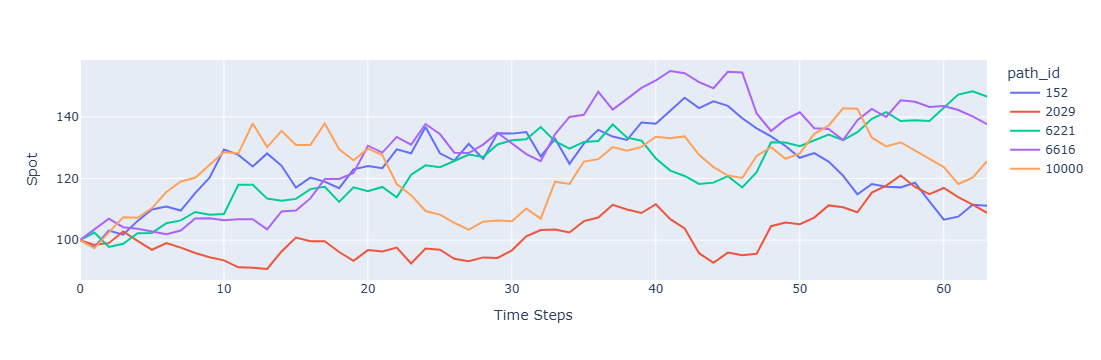

In [37]:
display(dsa_mostra_caminho_venda(spot_df, sel_path, 'Spot'))

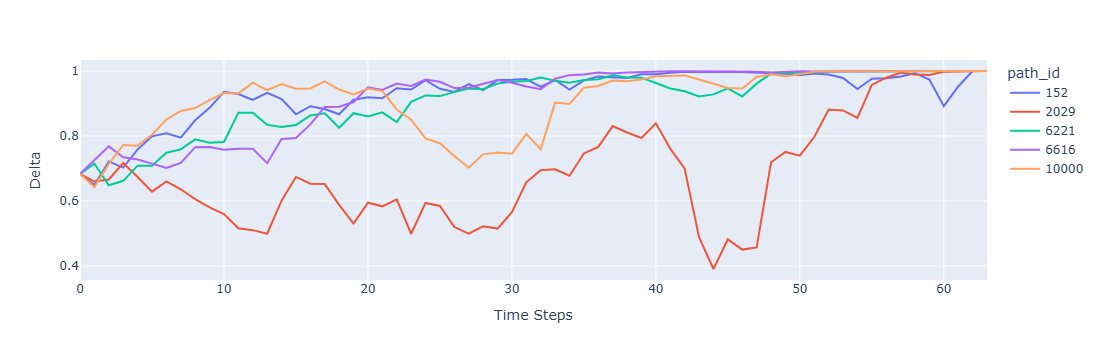

In [38]:
display(dsa_mostra_caminho_venda(delta_df, sel_path, 'Delta'))

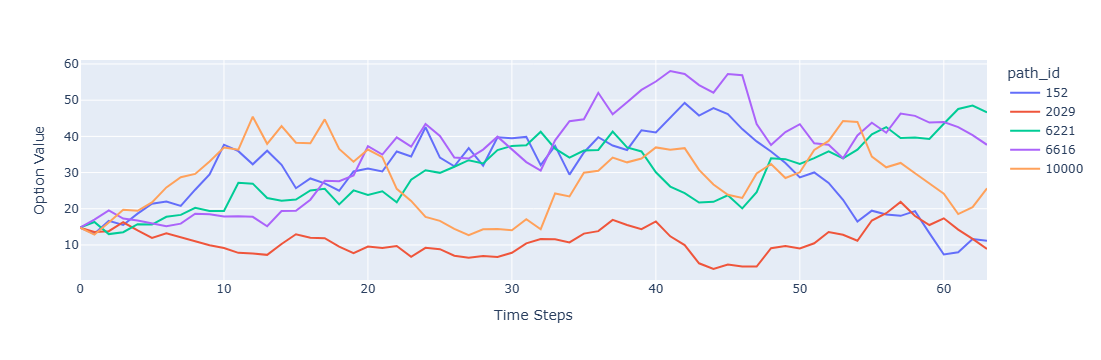

In [39]:
display(dsa_mostra_caminho_venda(option_value_df, sel_path, 'Option Value'))

## Pré-Processamento dos Dados Para Modelagem com Reinforcement Learning

Para o pré-processamento calculamos diferenças nas séries temporais (delta), normalizamos os dados (ajustando-os pela média) e os dividimos em conjuntos de treino e teste. 

In [40]:
# Cálculo de delta_s (variação no preço do ativo subjacente)
delta_s = np.exp(-r * delta_t) * spot_df.loc[:,1:num_of_timestep].values - spot_df.loc[:,0:num_of_timestep-1]

Esta linha calcula a variação do preço do ativo subjacente entre os passos de tempo, ajustando pelo fator de desconto, o que é necessário para trazer os valores futuros ao presente. 

O termo: **np.exp(-r * delta_t)** aplica o desconto pela taxa de juros livre de risco para um único passo de tempo. O cálculo da diferença:

**spot_df.loc[:,1:num_of_timestep].values - spot_df.loc[:,0:num_of_timestep-1]**

subtrai o preço da ação no passo de tempo anterior do preço no passo de tempo atual, obtendo assim a variação no preço (delta_s).

In [41]:
# Cálculo de delta_c (variação no valor da opção)
delta_c = np.exp(-r * delta_t) * option_value_df.loc[:,1:num_of_timestep].values - option_value_df.loc[:,0:num_of_timestep-1]

O cálculo de delta_c unciona de maneira similar ao cálculo de delta_s, mas neste caso estamos calculando a variação no valor da opção (não no preço da ação). A fórmula subtrai os valores da opção entre passos de tempo consecutivos e ajusta pelo fator de desconto. O resultado é a variação no valor da opção (delta_c).

In [42]:
# Índice para divisão dos dados em treino e teste
data_cutoff = int(num_of_path * 0.7)  

Os dados são divididos com base em um índice de corte (data_cutoff), que é 70% dos caminhos simulados. Aqui, o spot_df e delta_df (contendo os preços das ações e os deltas), bem como delta_s (variações nos preços) e delta_c (variações nos valores das opções) são divididos em conjuntos de treino e teste.

In [43]:
# Divisão dos dados em treino e teste 
spot_df_train, spot_df_test = spot_df[:data_cutoff], spot_df[data_cutoff:]

In [44]:
spot_df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
1,100,94.607893,95.851775,99.722386,99.084450,102.507813,104.440342,105.393510,101.953916,101.510622,...,92.137761,92.637450,94.364099,91.907526,95.921165,95.848230,93.269014,90.782774,91.005951,91.886620
2,100,100.229134,95.179909,92.151533,94.193009,96.668653,100.157937,95.747461,90.313984,91.571562,...,70.089482,71.830884,67.495876,67.322825,64.130244,68.700450,65.750906,63.548622,63.170463,60.394913
3,100,103.345619,103.470774,106.742247,109.631973,104.579744,100.757439,105.318745,108.853963,104.795249,...,112.748536,111.070658,110.491608,112.236746,108.488560,113.179752,112.537295,110.175265,108.262666,111.110970
4,100,101.624285,107.906035,109.936216,114.441076,122.721113,121.126577,123.956476,123.476971,127.893476,...,144.731877,143.700120,149.475609,155.546911,159.457429,153.177376,161.300813,160.649598,158.976836,161.688592
5,100,105.072992,106.102508,106.167495,109.298376,118.059803,114.695505,115.328701,125.556265,127.460955,...,188.081461,200.155908,198.331319,201.968075,195.326933,199.418289,200.353239,203.260759,212.730102,225.110566


In [45]:
# Divisão dos dados em treino e teste
delta_df_train, delta_df_test = delta_df[:data_cutoff], delta_df[data_cutoff:]

In [46]:
delta_df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
1,0.683075,0.601587,0.619043,0.675039,0.664349,0.711025,0.735283,0.746504,0.700125,0.692628,...,0.256604,0.255813,0.304653,0.1826,0.331864,0.298849,0.130265,0.022529,0.002407,0.0
2,0.683075,0.684883,0.608517,0.556643,0.588234,0.625936,0.677045,0.60706,0.510119,0.529863,...,0.000292,0.000332,0.000006,0.000001,0.0,0.0,0.0,0.0,0.0,0.0
3,0.683075,0.725814,0.726464,0.764906,0.795795,0.737825,0.685665,0.745576,0.786555,0.737516,...,0.919534,0.903853,0.905039,0.94372,0.893864,0.977848,0.985639,0.985304,0.99353,1.0
4,0.683075,0.703687,0.778259,0.799113,0.840726,0.899437,0.890397,0.907552,0.905538,0.928378,...,0.99996,0.999978,0.999999,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,0.683075,0.74682,0.75816,0.75831,0.792342,0.869284,0.843245,0.8488,0.9166,0.926433,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [47]:
# Divisão dos dados em treino e teste
delta_s_train, delta_s_test = delta_s[:data_cutoff], delta_s[data_cutoff:]

In [48]:
delta_s_train.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
1,-5.527165,1.107049,3.728252,-0.779384,3.277028,1.783435,0.802713,-3.585138,-0.588206,0.893503,...,-2.488123,0.367445,1.591940,-2.587776,3.876706,-0.209763,-2.712362,-2.615837,0.093261,0.749497
2,0.086052,-5.185099,-3.159926,1.907011,2.337644,3.346304,-4.547161,-5.562404,1.126855,-0.951332,...,3.568784,1.638859,-4.431361,-0.269158,-3.284131,4.472133,-3.043407,-2.293003,-0.468338,-2.861767
3,3.198088,-0.022555,3.119093,2.733220,-5.201521,-3.966142,4.410959,3.379823,-4.208314,-0.494620,...,-5.070429,-1.836437,-0.736783,1.584915,-3.903060,4.529622,-0.803109,-2.519311,-2.067150,2.689688
4,1.479211,6.127709,1.873241,4.341489,8.104846,-1.767450,2.652944,-0.655774,4.233931,-2.434940,...,-2.934636,-1.236897,5.562105,5.849251,3.682885,-6.498721,7.893172,-0.880551,-1.899709,2.480936
5,4.922995,0.878049,-0.086572,2.974852,8.592891,-3.528032,0.468559,10.048326,1.722733,-7.576181,...,6.200497,11.788714,-2.107718,3.348436,-6.919980,3.806676,0.648935,2.617355,9.165661,12.059107


In [49]:
# Divisão dos dados em treino e teste
delta_c_train, delta_c_test = delta_c[:data_cutoff], delta_c[data_cutoff:]

In [50]:
delta_c_train.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
1,-3.630905,0.599489,2.33742,-0.598324,2.178402,1.215169,0.520825,-2.671085,-0.488407,0.545597,...,-0.940925,-0.072758,0.257091,-0.813684,0.768186,-0.329462,-0.812288,-0.30215,-0.032642,-0.002106
2,-0.014818,-3.433566,-1.918779,1.014256,1.340982,2.102687,-3.00242,-3.192582,0.505681,-0.576722,...,0.000366,0.000054,-0.000548,-0.000006,-0.000001,0.0,-0.0,-0.0,-0.0,-0.0
3,2.18126,-0.088189,2.256008,2.065717,-4.063513,-2.900748,3.08351,2.518508,-3.282853,-0.44013,...,-4.849526,-1.775122,-0.778742,1.365701,-3.709498,4.175281,-0.832655,-2.525361,-2.086576,2.682184
4,0.952521,4.477409,1.411377,3.499961,7.013626,-1.629661,2.338355,-0.639844,3.841768,-2.289435,...,-2.934648,-1.236963,5.562041,5.849249,3.682885,-6.498721,7.893172,-0.880551,-1.899709,2.480936
5,3.451511,0.59114,-0.135295,2.238937,7.098178,-3.07897,0.337046,8.846382,1.546626,-6.920665,...,6.200497,11.788714,-2.107718,3.348436,-6.91998,3.806676,0.648935,2.617355,9.165661,12.059107


A normalização ajuda a tornar os dados mais adequados para modelagem, removendo a média de cada passo de tempo. Isso coloca os dados em uma escala centrada em zero, o que pode ser importante para alguns algoritmos de aprendizado de máquina ou análise estatística.

Aqui, delta_s_final_train e delta_c_final_train são os dados de treino normalizados, enquanto delta_s_final_test e delta_c_final_test são os dados de teste normalizados. A função .mean(axis = 0) calcula a média para cada passo de tempo (coluna).

In [51]:
# Normalização dos dados (remoção da média)
delta_s_final_train = delta_s_train - delta_s_train.mean(axis = 0)
delta_s_final_test = delta_s_test - delta_s_test.mean(axis = 0)
delta_c_final_train = delta_c_train - delta_c_train.mean(axis = 0)
delta_c_final_test = delta_c_test - delta_c_test.mean(axis = 0)

In [52]:
# Shape
delta_c_final_train.shape

(11468, 63)

In [53]:
delta_c_final_train.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
1,-3.7398,0.519053,2.297728,-0.67976,2.135133,1.160797,0.438969,-2.724129,-0.577843,0.486186,...,-1.046932,-0.129949,0.190615,-0.906174,0.696319,-0.424638,-0.919073,-0.406111,-0.108861,-0.124213
2,-0.123713,-3.514002,-1.95847,0.93282,1.297713,2.048314,-3.084276,-3.245627,0.416245,-0.636134,...,-0.105642,-0.057136,-0.067025,-0.092497,-0.071868,-0.095176,-0.106784,-0.103961,-0.076219,-0.122107
3,2.072365,-0.168625,2.216317,1.984281,-4.106782,-2.955121,3.001653,2.465463,-3.372289,-0.499541,...,-4.955533,-1.832313,-0.845219,1.27321,-3.781365,4.080105,-0.939439,-2.629323,-2.162795,2.560077
4,0.843626,4.396973,1.371685,3.418525,6.970357,-1.684034,2.256498,-0.692888,3.752332,-2.348846,...,-3.040655,-1.294154,5.495564,5.756758,3.611017,-6.593898,7.786388,-0.984512,-1.975929,2.35883
5,3.342616,0.510704,-0.174987,2.157501,7.054909,-3.133343,0.25519,8.793337,1.45719,-6.980077,...,6.094489,11.731524,-2.174194,3.255946,-6.991848,3.7115,0.542151,2.513393,9.089441,11.937


In [54]:
# Shape
delta_c_final_test.shape

(4915, 63)

In [55]:
delta_c_final_test.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
11469,-3.117381,0.675456,4.051305,1.481371,2.030352,2.044811,-1.207683,2.220301,-6.37048,1.455374,...,0.239497,-0.848569,0.614292,1.364839,0.447626,-2.363216,-0.248236,-0.77135,-0.005117,-0.071782
11470,0.582757,-0.647597,0.279307,1.54856,-1.406485,-0.128564,-2.437978,-2.923216,4.152993,0.701863,...,-3.260584,-0.875863,1.711134,1.340869,8.355315,4.51574,-3.799356,-1.330992,6.444881,-2.932077
11471,0.19404,-0.917669,0.434774,-3.044019,1.189664,-0.455416,-1.19438,-3.441821,-2.249759,1.209211,...,0.035602,-0.208954,-0.130004,-0.068043,-0.057062,-0.062833,-0.027948,-0.12683,0.052562,-0.066781
11472,-2.23575,-2.251847,5.155594,0.006852,1.405772,-0.526127,1.94296,-2.307649,3.5406,0.231882,...,-1.96289,7.758537,-9.623566,2.760556,5.018841,-0.406569,10.808792,-1.067535,-1.557568,-0.738083
11473,-1.093182,-3.48111,-0.179379,-0.043662,1.669782,-2.913467,-2.314805,-1.228886,-0.315689,0.218107,...,-0.529328,-0.617528,4.15777,-0.01613,6.702757,-7.528591,1.116129,-0.703365,-4.632181,-3.705803


## Fase 2 - Modelagem com Reinforcement Learning

## Modelando Uma Opção Financeira

A classe abaixo será usada para modelar uma opção financeira, que é um tipo de derivativo. Uma opção dá ao seu titular o direito, mas não a obrigação, de comprar ou vender um ativo subjacente (como uma ação) a um preço predeterminado (conhecido como preço de exercício ou "strike") em uma data futura específica (data de vencimento ou "expiry").
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
Esta classe representa os principais parâmetros de uma opção, como o preço inicial da ação, a volatilidade, a taxa de juros livre de risco e o tempo até o vencimento. Ela também contém um método chamado compute_value, que calcula o valor teórico da opção utilizando o modelo de Black-Scholes, uma fórmula amplamente usada para precificar opções.

Essa classe permite criar objetos que representam opções financeiras, armazenando seus parâmetros e fornecendo uma maneira de calcular o valor da opção com base em diferentes preços da ação ao longo do tempo.

In [56]:
# Classe Python
class Option:
    
    # Método de inicialização (construtor) da classe Option
    def __init__(self, 
                 s0 = 100,              # Preço inicial da ação
                 mu = 0.05,             # Taxa de retorno esperada da ação
                 sigma = 0.15,          # Volatilidade da ação
                 r = 0.03,              # Taxa de juros livre de risco
                 expiry = 3,            # Prazo até a expiração da opção (em anos)
                 num_of_timestep = 63,  # Número de intervalos de tempo a serem considerados
                 exercise_type = 'c'):  # Tipo de opção: 'c' para call (compra) e 'p' para put (venda)
        
        # Atribui o preço inicial da ação à variável de instância s0
        self.s0 = s0  
        
        # Atribui a taxa de retorno esperada à variável de instância mu
        self.mu = mu  
        
        # Atribui a volatilidade à variável de instância sigma
        self.sigma = sigma  
        
        # Atribui a taxa de juros livre de risco à variável de instância r
        self.r = r  
        
        # Atribui o tempo até o vencimento à variável de instância expiry
        self.expiry = expiry  
        
        # Atribui o número de passos de tempo à variável de instância num_of_timestep
        self.num_of_timestep = num_of_timestep  
        
        # Calcula e atribui o tamanho de cada intervalo de tempo (delta_t)
        self.delta_t = expiry / num_of_timestep  
        
        # Atribui o preço de exercício (strike) da opção como igual ao preço inicial da ação
        self.strike = s0  
        
        # Atribui o tipo de exercício da opção ('c' para call, 'p' para put)
        self.exercise_type = exercise_type  

    # Método para calcular o valor da opção com base no preço da ação
    def compute_value(self, stock_price):
        
        # Usa a função black_scholes para calcular o valor da opção e retorna o resultado
        return black_scholes(stock_price, self.strike, self.expiry, self.r, self.sigma, self.exercise_type)

## Modelando o Problema de Hedge (Proteção) em Opções

A classe abaixo serve para modelar um problema de hedge (proteção) em opções, simulando diferentes cenários de preços de ações e controlando a variação do valor de uma carteira de opções ao longo do tempo. O objetivo é gerenciar o risco associado às flutuações no preço das ações, ajustando a exposição do portfólio de acordo com o preço e a volatilidade das ações.

Essa classe permite:

**Inicializar os parâmetros do problema**: Ela recebe variações de preços de ações (ds), variações no valor da carteira (dc), um parâmetro delta para o ajuste da exposição (greekd) os preços das ações ao longo do tempo, e outras variáveis para controlar o ajuste fino dos cálculos.

**Simular o comportamento da ação e da opção**: O método T simula o preço da ação no próximo intervalo de tempo e ajusta o vencimento (maturidade) da opção, até o ponto em que a opção expira.
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
**Calcular o retorno (reward)**: O método R calcula o retorno para uma dada simulação, levando em conta a variação dos preços das ações e o impacto da ação tomada (por exemplo, ajustar a posição no mercado). Ele também considera o risco envolvido, penalizando decisões arriscadas com base em uma medida de aversão ao risco.

Essa classe será usada no modelo de proteção (hedging) de uma carteira de opções, para testar e simular estratégias que minimizam o risco das flutuações dos preços das ações. Ela permite ajustar a exposição da carteira para evitar perdas potenciais em mercados voláteis, considerando o comportamento futuro dos preços das ações.

In [57]:
# Classe Python
class Hedging:
    
    # Construtor
    def __init__(self, ds, dc, greekd, stock_prices, num_of_timestep, dstilde, dctilde, option = None):
        
        # Inicializa a opção, caso não seja fornecida, cria uma nova instância de Option
        self.option = option or Option()
        
        # Define o espaço de ações como uma matriz de valores de -1.1 a 0.1, com incrementos de 0.1
        self.A = np.arange(-1.1, 0.1, 0.1)   
        
        # Inicializa as variações de preço das ações (ds)
        self.ds = ds
        
        # Inicializa as variações no valor da carteira de opções (dc)
        self.dc = dc
        
        # Inicializa as variações ajustadas de preço das ações (dstilde)
        self.dstilde = dstilde
        
        # Inicializa as variações ajustadas no valor da carteira (dctilde)
        self.dctilde = dctilde
        
        # Inicializa o parâmetro grego delta (greekd)
        self.greekd = greekd
        
        # Inicializa os preços das ações para cada simulação
        self.stock_prices = stock_prices
        
        # Define o número de simulações com base no tamanho do conjunto de dados ds
        self.num_simulations = len(self.ds)
        
        # Define o número de passos de tempo
        self.num_of_timestep = num_of_timestep

    # Método T
    def T(self, simulation, current_date, maturity):
        
        # Se a data atual for maior ou igual ao número de passos de tempo, a opção expira e a simulação termina
        if current_date >= self.num_of_timestep:
            return (None, None)  # A opção expira, simulação termina
        
        # Obtém o próximo preço da ação para esta simulação e data atual
        next_stock_price = self.stock_prices.iloc[simulation, current_date + 1]
        
        # Calcula a nova maturidade, subtraindo o delta_t da opção
        next_maturity = maturity - self.option.delta_t
        
        # Retorna o próximo preço da ação e a nova maturidade
        return (next_stock_price, next_maturity)

    # Método R
    def R(self, simulation, current_date, action):
        
        # Se a data atual for maior ou igual ao número de passos de tempo, o retorno é zero
        if current_date >= self.num_of_timestep:
            return 0
        
        # Obtém o valor de ds para esta simulação e data atual
        dst = self.ds.iloc[simulation, current_date]  
        
        # Obtém o valor de dc para esta simulação e data atual
        dct = self.dc.iloc[simulation, current_date]  
        
        # Calcula o valor de dw, considerando a ação tomada e as variações de ds e dc
        dw = (action * dst) + dct  

        # Calcula o retorno (reward), levando em consideração o risco (risk_aversion) e a variação ajustada
        reward = dw - (risk_aversion / 2) * ((action * self.dstilde.iloc[simulation, current_date] +
                                          self.dctilde.iloc[simulation, current_date]) ** 2)
        # Retorna o valor do retorno calculado
        return reward

## Construindo o Módulo de Memória do Agente

A classe abaixo é usada para armazenar e gerenciar dados de forma eficiente, especialmente em cenários onde uma "memória" ou histórico de experiências é necessário, como no aprendizado por reforço (Reinforcement Learning). Ela permite o armazenamento e a amostragem de experiências passadas, o que é útil para treinar modelos de IA, especialmente agentes que aprendem com interações com o ambiente.

Principais funcionalidades:

**Armazenamento de dados**: A classe utiliza uma estrutura de dados chamada deque, que permite armazenar dados de forma eficiente. Se for definido um comprimento máximo (max_length), a deque funcionará como uma fila circular, descartando os elementos mais antigos quando atingir o limite.

**Armazenamento incremental**: O método store adiciona novos dados à memória. Se o limite de comprimento for atingido, os dados mais antigos serão removidos automaticamente.

**Amostragem aleatória**: O método _sample permite selecionar uma amostra aleatória de um tamanho definido (k) da memória armazenada. Isso é útil para evitar correlações entre os dados durante o treinamento de modelos, especialmente em redes neurais, promovendo melhor generalização.

**Amostragem estruturada**: O método structured_sample organiza os dados amostrados em um formato específico. Ele extrai diferentes partes da experiência armazenada (como estado, ação, recompensa, etc.) e os retorna em um dicionário estruturado, o que é comum em algoritmos de aprendizado por reforço.

**Controle de tamanho da memória**: O método __len__ permite verificar quantos elementos estão armazenados na memória no momento.

Essa classe é útil para agentes de aprendizado por reforço, onde o armazenamento de experiências passadas (transições entre estados e recompensas) e a capacidade de reprocessá-las para aprendizado são essenciais para o treinamento eficiente do modelo.

In [58]:
# Classe Python
class ReplayMemory:
    
    # Construtor
    def __init__(self, max_length = None):
        
        # Inicializa o comprimento máximo da memória 
        self.max_length = max_length
        
        # Cria uma deque (fila de dois lados) para armazenar os dados, com comprimento máximo definido
        self.memory = deque(maxlen = max_length)

    def store(self, data):
        
        # Armazena os dados na memória (adiciona ao final da deque)
        self.memory.append(data)

    def _sample(self, k):
        
        # Retorna uma amostra aleatória de k elementos da memória
        return random.sample(self.memory, k)

    def structured_sample(self, k):
        
        # Obtém uma amostra estruturada de k elementos da memória
        batch = self._sample(k)
        
        # Inicializa um dicionário vazio para armazenar o resultado
        result = {}
        
        # Para cada parte da memória (definida em memory_parts), armazena a amostra correspondente
        for i, part in enumerate(memory_parts):
            result[part] = np.array([row[i] for row in batch])

        # Retorna o dicionário resultante com as amostras estruturadas
        return result

    def __len__(self):
        
        # Retorna o comprimento atual da memória (quantidade de elementos armazenados)
        return len(self.memory)

In [59]:
# Elementos da memória
memory_parts = ["spot", "maturity", "action", "next_spot", "next_maturity", "reward"]

In [60]:
# Cria uma namedtuple chamada Memory, uma estrutura de dados semelhante a uma tupla, 
# mas com a vantagem de permitir acesso aos elementos por nome, como se fossem atributos de um objeto, 
# além do acesso por índice, como nas tuplas comuns.
Memory = namedtuple("Memory", memory_parts) 

In [61]:
# Cria instância da classe
dsa_hedge = Hedging(ds = delta_s_train, 
                    dc = delta_c_train, 
                    greekd = delta_df_train, 
                    stock_prices = spot_df_train, 
                    num_of_timestep = num_of_timestep,
                    dstilde = delta_s_final_train, 
                    dctilde = delta_c_final_train)  

## Construção do Modelo Deep Q-Network
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
O Modelo DQN (Deep Q-Network) é um algoritmo de aprendizado por reforço profundo (Deep Reinforcement Learning) que combina redes neurais com a técnica de Q-Learning para treinar agentes a tomar decisões ótimas em ambientes complexos. Foi introduzido pela primeira vez pela equipe do Google DeepMind em 2015, sendo famoso por superar seres humanos em jogos de Atari.

In [62]:
# Hiperparâmetros
eps = 0.4
eps_decay = 0.95
min_eps = 0.1
lr = 0.01
loss_func = 'mean_squared_error'

In [63]:
# Cria o modelo
dsa_qmodel = Sequential()

In [64]:
# Adiciona as camadas
dsa_qmodel.add(Dense(units = 8, input_dim = 3, activation = 'relu'))
dsa_qmodel.add(Dense(units = 16, activation = 'relu'))
dsa_qmodel.add(Dense(units = 8, activation = 'tanh'))
dsa_qmodel.add(Dense(units = 1, activation = 'linear'))

In [65]:
# Compila o modelo
dsa_qmodel.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss = loss_func)

In [66]:
# Sumário
dsa_qmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

## Definindo a Política

Essa política implementa uma função de decisão para o agente que utiliza uma abordagem de aprendizado por reforço para escolher a melhor ação (greedy action) com base em um modelo de valor Q. O modelo Q avalia o valor de recompensa esperada ao tomar certas ações sob diferentes condições de mercado.

Aqui está uma explicação do processo:

**Verificação de maturidade**: Se o valor da maturidade for praticamente zero, isso significa que a opção expirou e não há mais necessidade de calcular uma ação, então a função retorna None para a ação e 0 como valor de recompensa.
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
**Inicialização**: A função inicializa a variável greedy_action como None e best_Q como menos infinito, garantindo que qualquer valor de Q calculado posteriormente será maior que esse valor inicial.

**Iteração sobre as ações**: O laço percorre todas as ações possíveis definidas no conjunto de ações (hedge.A). Para cada ação, a função cria um conjunto de dados de entrada que inclui o preço do ativo (spot), a maturidade e a ação.

**Previsão do modelo Q**: O modelo Qmodel faz uma previsão do valor de Q para o conjunto de dados de entrada. O valor de Q representa a qualidade da ação escolhida com base nas condições atuais.

**Seleção da melhor ação**: Se o valor de Q atual for maior que o valor armazenado em best_Q, a ação e o valor de Q são atualizados.
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
**Retorno**: A função retorna a melhor ação encontrada de forma gulosa (greedy) e o respectivo valor de Q associado a essa ação.

In [67]:
# Função
def dsa_policy(spot, maturity, Qmodel, hedge):
    
    # Se a maturidade for muito pequena (ou zero), a opção expira e não há ação a ser tomada
    if abs(maturity) < 0.001:
        return (None, 0)
    
    # Inicializa a variável para armazenar a melhor ação gulosa (greedy) como None
    greedy_action = None
    
    # Define o melhor valor de Q inicial como o menor valor possível (menos infinito)
    best_Q = float('-inf')
    
    # Itera sobre todas as ações possíveis no conjunto hedge.A
    for action in hedge.A:
        
        # Cria os dados de entrada para o modelo Q, incluindo o preço do ativo (spot), a maturidade e a ação
        input_data = tf.constant([[spot, maturity, action]])
        
        # Calcula o valor de Q para essa ação usando o modelo Q
        Qvalue = Qmodel.predict(input_data, verbose = 0)[0, 0]

        # Se o valor de Q atual for melhor que o melhor valor de Q encontrado até agora
        if Qvalue > best_Q:
            
            # Atualiza a melhor ação gulosa com a ação atual
            greedy_action = action
            
            # Atualiza o melhor valor de Q com o valor atual de Q
            best_Q = Qvalue

    # Retorna a melhor ação gulosa encontrada e seu respectivo valor de Q
    return (greedy_action, best_Q)

## Executando o Treinamento do Modelo (Agente)

In [68]:
# Cria o objeto
replay_memory = ReplayMemory(max_length = 10000)

In [69]:
# Número de amostras a serem extraídas para repetição da experiência
batch_size = 50  

In [70]:
# Comprimento mínimo da memória de repetição antes do início do treinamento
min_length = 500  

In [71]:
# Se a memória de replay for pequena, utilizaremos uma aproximação baseada no delta para escolher a ação
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

Pontos Principais do Loop de Simulação:

**Simulação e ponto de verificação**: A primeira parte do código cria um loop que executa simulações e salva pontos de verificação do modelo em arquivos .keras a cada 5 iterações. O callback ModelCheckpoint é configurado para salvar o modelo após o treinamento de cada lote.

**Inicialização de variáveis**: Para cada simulação, o preço inicial da ação (spot) e a maturidade da opção são definidos a partir dos parâmetros do objeto hedge.

**Escolha da ação**: Se a memória de replay tiver um tamanho adequado, uma ação é escolhida com base em uma política epsilon-greedy: com uma probabilidade eps, uma ação aleatória é selecionada, e com a probabilidade complementar, a ação é escolhida usando a função gulosa (greedy) baseada no modelo Q. Caso a memória seja pequena, a escolha da ação é feita com base em um valor aproximado do delta.
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
**Cálculo da recompensa**: O valor de recompensa é calculado usando o método R da classe hedge.

**Armazenamento na memória de replay**: A transição (estado atual, ação, estado futuro, recompensa) é armazenada na memória de replay.

**Amostragem e treinamento**: Se a memória de replay for grande o suficiente, o modelo Q é treinado. Um lote de amostras estruturadas é retirado da memória, os valores de Q* são calculados para essas amostras e o modelo é treinado usando esses valores.

**Decaimento de epsilon**: Após cada simulação, o valor de eps é decaído para reduzir gradualmente a exploração (ações aleatórias) e aumentar a exploração (ações baseadas no modelo) ao longo do tempo.

In [ ]:
%%time

# Loop para a simulação
for simulation in tqdm(range(0, 15)):
    
    # Exibe a mensagem indicando que a simulação começou
    print(f"Iniciando simulação {simulation}")

    # Define o caminho para salvar o ponto de verificação do modelo para cada simulação
    checkpoint_path = f"modelos/dsa{simulation}.keras"
    
    # Cria o callback para salvar o modelo em pontos de verificação a cada 5 iterações
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                     verbose = 2, 
                                                     save_weights_only = False, 
                                                     save_freq = 5)
    
    # Inicializa o preço da ação com o preço inicial da opção
    spot = dsa_hedge.option.s0
    
    # Define a maturidade inicial da opção
    maturity = dsa_hedge.option.expiry

    # Loop sobre cada dia dentro do número de passos de tempo da simulação
    for day in range(dsa_hedge.num_of_timestep):
        
        # Verifica se a memória de replay tem o comprimento mínimo necessário
        if len(replay_memory) >= min_length:
            
            # Escolhe uma ação aleatória com probabilidade eps ou a ação gulosa usando o modelo Q
            if random.random() < eps:
                action = random.choice(dsa_hedge.A)
            else:
                action = dsa_policy(spot, maturity, dsa_qmodel, dsa_hedge)[0]
                print(action)
        else:
            # Se a memória de replay for pequena, utiliza uma aproximação baseada no delta para escolher a ação
            delta_value = -1 * dsa_hedge.greekd.iloc[simulation, day]
            action = find_nearest(dsa_hedge.A, delta_value)

        # Calcula a recompensa para a ação escolhida
        rwrd = dsa_hedge.R(simulation, day, action)
        
        # Obtém o próximo preço da ação e a nova maturidade
        (next_spot, next_maturity) = dsa_hedge.T(simulation, day, maturity)

        # Armazena a transição (estado atual, ação, estado futuro, recompensa) na memória de replay
        memory = Memory(spot, maturity, action, next_spot, next_maturity, rwrd)
        replay_memory.store(memory)

        # Se a memória de replay tiver o comprimento mínimo necessário
        if len(replay_memory) >= min_length:
            
            # Obtém um lote estruturado de amostras da memória de replay
            batch = replay_memory.structured_sample(batch_size) 
            
            # Inicializa listas para armazenar dados de entrada e alvos
            input_data = []
            targets = []
            
            # Preenche os dados de entrada e os alvos para o treinamento do modelo
            for replay_sample in range(batch_size):
                
                # Append dos dados de entrada
                input_data.append([batch['spot'][replay_sample],
                                   batch['maturity'][replay_sample],
                                   batch['action'][replay_sample]])
                
                # Calcula o valor alvo Q* usando o modelo Q e a ação gulosa
                Q_star = batch['reward'][replay_sample] + gamma * dsa_policy(batch['next_spot'][replay_sample],
                                                                             batch['next_maturity'][replay_sample],
                                                                             dsa_qmodel, 
                                                                             dsa_hedge)[1]
                targets.append([Q_star])

            # Converte os dados de entrada e alvos para tensores do TensorFlow
            input_data = tf.constant(input_data)
            targets = tf.constant(targets)
            
            # Treina o modelo Q usando os dados de entrada e os alvos
            dsa_qmodel.fit(input_data, 
                           targets, 
                           epochs = 1, 
                           batch_size = batch_size, 
                           verbose = 1, 
                           callbacks = [cp_callback])

        # Atualiza o estado atual (spot e maturity) para o próximo estado
        (spot, maturity) = (next_spot, next_maturity)

    # Decai o valor de epsilon para reduzir a exploração e aumentar a exploração ao longo do tempo
    eps = max(min_eps, eps * eps_decay)
    
    # Exibe a mensagem indicando que a simulação terminou
    print(f"Simulação {simulation} concluída")

  0%|          | 0/15 [00:00<?, ?it/s]

Iniciando simulação 0
Simulação 0 concluída
Iniciando simulação 1
Simulação 1 concluída
Iniciando simulação 2
Simulação 2 concluída
Iniciando simulação 3
Simulação 3 concluída
Iniciando simulação 4
Simulação 4 concluída
Iniciando simulação 5
Simulação 5 concluída
Iniciando simulação 6
Simulação 6 concluída
Iniciando simulação 7


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1808
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1726
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0809
-1.1

Epoch 1: saving model to modelos/dsa9.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0833
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5514
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4787
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3927
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5117

Epoch 1: saving model to modelos/dsa9.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2014
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0709
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4202
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1935
-1.1

Epoch 1: saving model to modelos/dsa9.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0634
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1069
-1.1
1/1 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4075
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1790
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3003
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4982
-1.1

Epoch 1: saving model to modelos/dsa10.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7671
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0521
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6102
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4732
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9502
-1.1

Epoch 1: saving model to modelos/dsa10.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7354
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6110
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2813
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2690
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6110
-1.1

Epoch 1: saving model to modelos/dsa10.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6433
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0276
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0364
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8215
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7931
-1.1

Epoch 1: saving model to modelos/dsa11.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1091
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4837
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5981
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1132
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0613
-1.1

Epoch 1: saving model to modelos/dsa11.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5729
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4080
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7426
Simulação 11 concluída
Iniciando simulação 12
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1807
-1.1
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4057
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2020
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7491

Epoch 1: saving model to modelos/dsa13.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8391
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9400
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6187
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7646
-1.1

Epoch 1: saving model to modelos/dsa13.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7511
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1484
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1817
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2216
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6895

Epoch 1: saving model to modelos/dsa13.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4797
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1586
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9797
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8377
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9861
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1547
-1.1

Epoch 1: saving model to modelos/dsa14.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4982
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4813
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5769
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7086
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2535
-1.1

Epoch 1: saving model to modelos/dsa14.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0825
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3764
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0571
-1.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7675
-1.1

Epoch 1: saving model to modelos/dsa14.keras
1/1 ━━━━━

In [ ]:
# Salva o modelo final em disco
dsa_qmodel.save('modelos/dsa_qmodel.keras')

## Funções Para Cálculo da Recompensa

O modelo aprendeu a investir de modo a obter o melhor resultado possível na estratégia de hedging. A função abaixo vai calcular a recompensa para avaliarmos o modelo e então compará-lo com o delta da opção (que não usa IA). Ou seja, vamos comparar duas estratégias, com e sem IA. Aqui estão os pontos principais da função:

**Inicialização do problema de hedge**: A função começa inicializando um objeto Hedging chamado hedge_eval, que utiliza os dados de teste fornecidos, como variações de preço e valores delta (delta_s_test, delta_c_test, etc.).

**Criação dos DataFrames**: Dois DataFrames vazios são criados: reward_calc para armazenar as recompensas e action_calc para armazenar as ações tomadas durante as avaliações. O índice desses DataFrames é igual ao índice de delta_s_test e as colunas representam o número de passos de tempo.

**Loop de avaliação**: A função executa n_evals simulações para avaliar a política de hedge. Para cada simulação (eval), o preço inicial (spot) e a maturidade da opção são definidos.

**Escolha da ação**: Em cada dia da simulação, dependendo do mode, a função escolhe uma ação:

- 'ql' (Q-learning): A ação é escolhida usando uma abordagem gulosa (greedy) com base no modelo loaded_model.
- 'delta': A ação é escolhida com base no valor do delta da opção.
- Exceção: Se o mode não for 'ql' ou 'delta', a função levanta uma exceção.

**Armazenamento de ações e recompensas**: A função armazena a ação selecionada no DataFrame action_calc e a recompensa calculada no DataFrame reward_calc.

**Atualização dos estados**: O preço da ação (spot) e a maturidade são atualizados a cada iteração com base nos novos valores calculados pela função T da classe HedgingProblem.

**Retorno**: No final, a função retorna os DataFrames reward_calc e action_calc que contêm, respectivamente, as recompensas e as ações calculadas para cada simulação e cada passo de tempo.

Esse processo permite comparar o desempenho de diferentes estratégias de hedge, como Q-learning (mode='ql') ou com base no delta (mode='delta').

In [ ]:
# Função
def dsa_calcula_reward(mode = 'ql', n_evals = 10):
    
    # Inicializa o problema de hedge com os dados de teste (delta_s_test, delta_c_test, etc.)
    hedge_eval = Hedging(ds = delta_s_test, 
                         dc = delta_c_test, 
                         greekd = delta_df_test, 
                         stock_prices = spot_df_test, 
                         num_of_timestep = num_of_timestep,
                         dstilde = delta_s_final_test, 
                         dctilde = delta_c_final_test) 

    # Cria um DataFrame vazio para armazenar as recompensas calculadas, com o mesmo índice de delta_s_test
    reward_calc = pd.DataFrame([], index = delta_s_test.index, columns = range(num_of_timestep))
    
    # Cria um DataFrame vazio para armazenar as ações (decisões) do modelo
    action_calc = pd.DataFrame([], index = delta_s_test.index, columns = range(num_of_timestep))
    
    # Loop para avaliar o hedge, executado n_evals vezes
    for eval in tqdm(range(n_evals)):
        
        # Inicializa o preço da ação e a maturidade a partir da opção
        spot = hedge_eval.option.s0
        maturity = hedge_eval.option.expiry

        # Loop sobre cada dia dentro do número de passos de tempo
        for day in range(dsa_hedge.num_of_timestep):
            
            # Se o modo for 'ql' (Q-learning), seleciona a ação gulosa (greedy) usando o modelo carregado
            if mode == 'ql':
                action = dsa_policy(spot, maturity, loaded_model, hedge_eval)[0]
            
            # Se o modo for 'delta', seleciona a ação com base no valor do delta (sem usar IA)
            elif mode == 'delta':
                delta_value = -1 * delta_df_test.iloc[eval, day]
                action = find_nearest(hedge_eval.A, delta_value)
            
            # Se o modo não for suportado, gera uma exceção
            else:
                raise Exception('Modo não suportado')

            # Armazena a ação calculada no DataFrame action_calc
            action_calc.iloc[eval, day] = action
            
            # Calcula a recompensa para a ação e a armazena no DataFrame reward_calc
            rwrd = hedge_eval.R(eval, day, action)
            reward_calc.iloc[eval, day] = rwrd

            # Atualiza o preço da ação e a maturidade para o próximo passo de tempo
            (next_spot, next_maturity) = hedge_eval.T(eval, day, maturity)
            (spot, maturity) = (next_spot, next_maturity)

    # Retorna os DataFrames de recompensas e ações calculadas
    return reward_calc, action_calc

> A função abaixo será usada para calcular a recompensa total.

A função calcula a recompensa média para o passo de tempo t usando reward_calc.loc[:, t].mean(). Essa recompensa média é multiplicada por um fator de desconto exponencial, dado por np.exp(-r * delta_t * t), onde r é a taxa de juros e delta_t é o intervalo de tempo entre os passos.

A recompensa descontada para cada passo de tempo é somada à variável total_reward, que acumula o valor total. A função retorna o valor da recompensa total acumulada ao final do loop, considerando o efeito do desconto em cada passo de tempo.

In [ ]:
# Função
def dsa_calcula_total_reward(reward_calc):
    
    # Cria uma cópia do DataFrame de recompensas para evitar modificações no original
    reward_calc = reward_calc.copy()
    
    # Inicializa a variável para armazenar a recompensa total
    total_reward = 0.0
    
    # Loop sobre cada passo de tempo no intervalo definido por num_of_timestep
    for t in range(num_of_timestep):
        
        # Calcula a recompensa descontada para o passo de tempo t e soma à recompensa total
        total_reward = total_reward + np.exp(-r * delta_t * t) * reward_calc.loc[:, t].mean()
    
    # Retorna a recompensa total acumulada
    return total_reward

## Avaliando a Estratégia de Hedge nos Passos de Tempo

In [ ]:
# Carrega o modelo do disco
loaded_model = tf.keras.models.load_model('modelos/dsa_qmodel.keras')

In [ ]:
%%time

# Recompensa ao longo do tempo usando o modelo de aprendizado por reforço
reward_q, action_q = dsa_calcula_reward(mode = 'ql', n_evals = 10)

In [ ]:
%%time

# Recompensa ao longo do tempo usando o delta hedge (medida de sensibilidade, sem usar IA)
reward_delta, action_delta = dsa_calcula_reward(mode = 'delta', n_evals = 10)

In [ ]:
# Calcula a recompensa total
total_reward_q = dsa_calcula_total_reward(reward_q)
total_reward_delta = dsa_calcula_total_reward(reward_delta)

In [ ]:
total_reward_q, total_reward_delta

In [ ]:
# Plot

# Cria uma lista de scatter plots
scatter_list = [go.Scatter(x = reward_delta.columns, 
                           y = reward_delta.mean(axis = 0).values, 
                           line = dict(dash = 'dash'),  
                           name = 'Delta Hedge'),
                go.Scatter(x = reward_q.columns, 
                           y = reward_q.mean(axis = 0).values, 
                           name = 'Q-Learning Hedge')]

# Cria o layout
layout = go.Layout(title = go.layout.Title(text = '', x = 0.5),
                   width = 800,
                   height = 400)

fig = go.Figure(data = scatter_list, layout = layout)
fig.update_layout(xaxis_title = "Timestep", yaxis_title = "Recompensa", margin = dict(t = 10))
fig.show()

In [ ]:
%watermark -a "Data Science Academy"

In [ ]:
#%watermark -v -m

In [ ]:
#%watermark --iversions

# Fim